# Process the ATL06-SR data prior to DEM sampling 
________________________

Some of this code was originally adapted by Hannah Besso from code written by David Shean in 2021
______________

### Steps In This Notebook:    
* Reproject ATL06-SR data to local coordinate reference system
* Label ATL06SR data as snow-on (snow_presence = 1) or snow-off (snow_presence = 0) based on snow presence at SNOTEL sites.   

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from astropy.time import Time
import datetime
import pickle

In [2]:
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', None)

In [6]:
#Add DOY and DOWY column
def add_dowy(df, col=None):
    print("Adding Day of Water Year (DOWY)")
    if col is None:
        df['doy'] = df.index.dayofyear
        df['decyear'] = Time(df.index).decimalyear
    else:
        df['doy'] = pd.to_datetime(df[col]).dt.dayofyear
        df['decyear'] = Time(pd.to_datetime(df[col])).decimalyear
    
    #df['dowy'] = (df['doy'].index - pd.DateOffset(months=9)).dayofyear
    # Sept 30 is doy 273
    df['dowy'] = df['doy'] - 273
    df.loc[df['dowy'] <= 0, 'dowy'] += 365

# Load SlideRule

In [9]:
atl06sr = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10182022.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_68144/1215892880.py:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  atl06sr = pickle.load(open('../../data/atl06/methow_all_sr-atl06-10182022.pkl', 'rb'))


In [11]:
atl06sr.head(2)

pflags      h_mean  dh_fit_dy  spot  \
time                                                                 
2018-11-09 22:09:43.662511060       0  774.110259        0.0     5   
2018-11-09 22:09:43.789049908       0  919.941824        0.0     5   

                               w_surface_window_final   h_sigma      distance  \
time                                                                            
2018-11-09 22:09:43.662511060                9.386548  0.079705  5.382001e+06   
2018-11-09 22:09:43.789049908                3.000000  0.050617  5.382903e+06   

                               segment_id  dh_fit_dx  rgt  cycle  \
time                                                               
2018-11-09 22:09:43.662511060      268398   0.367318  646      1   
2018-11-09 22:09:43.789049908      268443   0.028568  646      1   

                                 delta_time  gt  n_fit_photons  rms_misfit  \
time                                                                         
2018-11-09 22:09:43.662511060  2.703658e+07  20             41    0.506044   
2018-11-09 22:09:43.789049908  2.703658e+07  20             42    0.305572   

                                                  geometry     acqdate  
time                                                                    
2018-11-09 22:09:43.662511060  POINT (-120.00053 48.33917)  2018-11-09  
2018-11-09 22:09:43.789049908  POINT (-120.00167 48.34723)  2018-11-09

In [11]:
add_dowy(atl06sr_gdf)

Adding Day of Water Year (DOWY)


### Set the CRS to a more detailed EPSG code for a more accurate transformation:

In [10]:
atl06sr_gdf = atl06sr.set_crs('epsg:7912', allow_override=True)

## Load a polygon of the study area

In [12]:
outline_gdf = pickle.load(open('../../data/site_outlines/methow_outline_4326.pkl', 'rb'))

/var/folders/yr/1f67jccn6hl_lyxnqy7qjpq40000gp/T/ipykernel_68144/896896808.py:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  outline_gdf = pickle.load(open('../../data/site_outlines/methow_outline_4326.pkl', 'rb'))


### Plot the data:

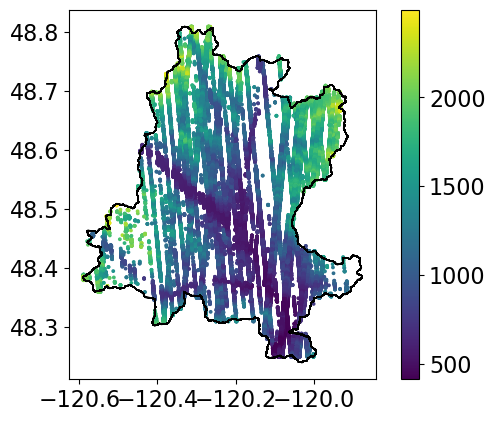

In [17]:
fig, ax = plt.subplots()

atl06sr_gdf.plot(column='h_mean', ax=ax, markersize=3, legend=True)
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k');

### Load snow data, cleaned in AUX_data_clean.ipynb:

In [14]:
snwd = pickle.load(open('../data/snotel/snotel_snwd_35.pkl', 'rb'))

In [25]:
snwd.head(2)

Muckamuck  Salmon Meadows  doy      decyear  dowy     acqdate
2018-10-03        0.0             0.0  276  2018.753425     3  2018-10-03
2018-10-04        0.0             0.0  277  2018.756164     4  2018-10-04

### Plot the in situ snow depth:

Text(0, 0.5, 'Snow Depth m')

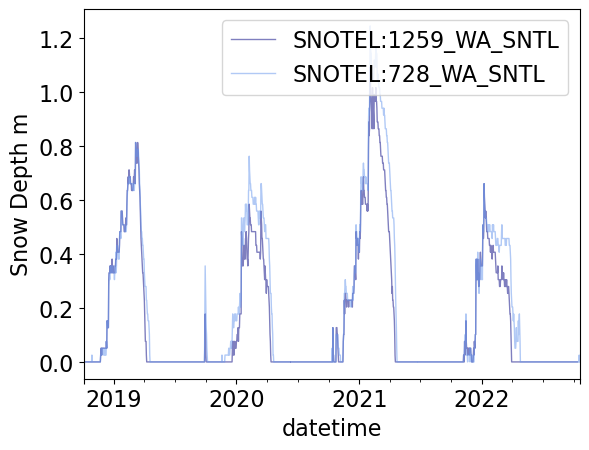

In [31]:
fig, ax = plt.subplots()
snwd[['SNOTEL:1259_WA_SNTL','SNOTEL:728_WA_SNTL']].plot(alpha=0.5, color=['navy', 'cornflowerblue'], lw=1, ax=ax)
#ax.axhline(y = 0, c = 'k')
plt.ylabel('Snow Depth m')

### Determine average snow-free dates:

In [15]:
idx_st = (snwd[['Muckamuck', 'Salmon Meadows']] < 0.1).all(axis=1)

(90.0, 360.0)

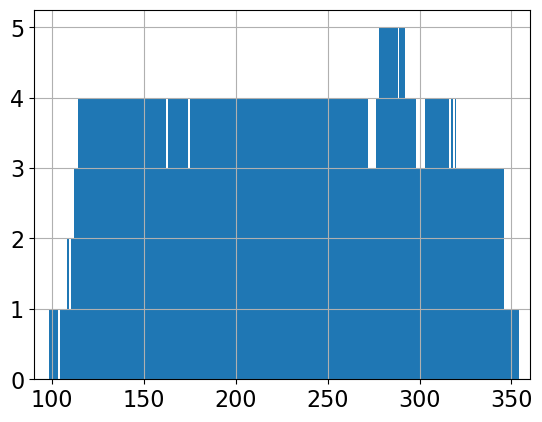

In [19]:
fig, ax = plt.subplots()
snwd[idx_st]['doy'].hist(bins=365, range=(0,365), ax=ax)
ax.set_xlim(90, 360)

In [16]:
snowfree_doy_range = (100,350)

In [17]:
snowoff_days_percent = (snowfree_doy_range[1] - snowfree_doy_range[0]) / 360 * 100
snowoff_days_percent

69.44444444444444

## Label data as snow off or snow on:

In [18]:
idx = (atl06sr_gdf['doy'] >= snowfree_doy_range[0]) & (atl06sr_gdf['doy'] <= snowfree_doy_range[1])

In [19]:
atl06sr_gdf['snow_presence'] = ""
atl06sr_gdf.loc[idx, 'snow_presence'] = 0
atl06sr_gdf.loc[~idx, 'snow_presence'] = 1

### Plot the occurence of snow-on and snow-off data:

Text(0.5, 1.0, 'Snow On')

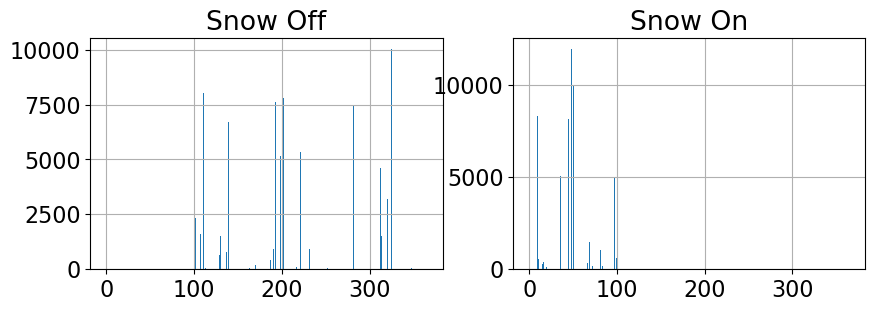

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
atl06sr_gdf['doy'][atl06sr_gdf['snow_presence'] == 0].hist(bins=365, range=(0,365), ax=ax[0])
atl06sr_gdf['doy'][atl06sr_gdf['snow_presence'] == 1].hist(bins=365, range=(0,365), ax=ax[1])
ax[0].set_title('Snow Off')
ax[1].set_title('Snow On')

### Save as a new file:

In [21]:
# Save progress: save ATL06SR file prior to DEM differencing (done on Oct 18, 2022 to save my progress in this notebook temporarily)

atl06sr_temp_fn = '../../data/atl06/methow_all_sr-atl06-10172022_processed_wo-dems_7912.pkl'

with open(atl06sr_temp_fn, 'wb') as f:
    pickle.dump(atl06sr_gdf, f)